In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
GPU: NVIDIA GeForce RTX 3070


hi
Using device: cuda


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


First stage training (frozen layers)
Epoch 1/15:
Train Loss: 0.5022, Acc: 0.8741
Val Loss: 0.1464, Acc: 0.9597
Epoch 2/15:
Train Loss: 0.2185, Acc: 0.9350
Val Loss: 0.1243, Acc: 0.9616
Epoch 3/15:
Train Loss: 0.1929, Acc: 0.9420
Val Loss: 0.1155, Acc: 0.9629
Epoch 4/15:
Train Loss: 0.1803, Acc: 0.9451
Val Loss: 0.1107, Acc: 0.9660
Epoch 5/15:
Train Loss: 0.1725, Acc: 0.9455
Val Loss: 0.1126, Acc: 0.9650
Epoch 6/15:
Train Loss: 0.1628, Acc: 0.9484
Val Loss: 0.1088, Acc: 0.9670
Epoch 7/15:
Train Loss: 0.1629, Acc: 0.9477
Val Loss: 0.1118, Acc: 0.9647
Epoch 8/15:
Train Loss: 0.1528, Acc: 0.9515
Val Loss: 0.1132, Acc: 0.9622
Epoch 9/15:
Train Loss: 0.1521, Acc: 0.9531
Val Loss: 0.1130, Acc: 0.9637
Epoch 10/15:
Train Loss: 0.1481, Acc: 0.9531
Val Loss: 0.1108, Acc: 0.9658
Epoch 11/15:
Train Loss: 0.1406, Acc: 0.9542
Val Loss: 0.1051, Acc: 0.9679
Epoch 12/15:
Train Loss: 0.1359, Acc: 0.9557
Val Loss: 0.1100, Acc: 0.9660
Epoch 13/15:
Train Loss: 0.1368, Acc: 0.9559
Val Loss: 0.1040, Acc: 0.96

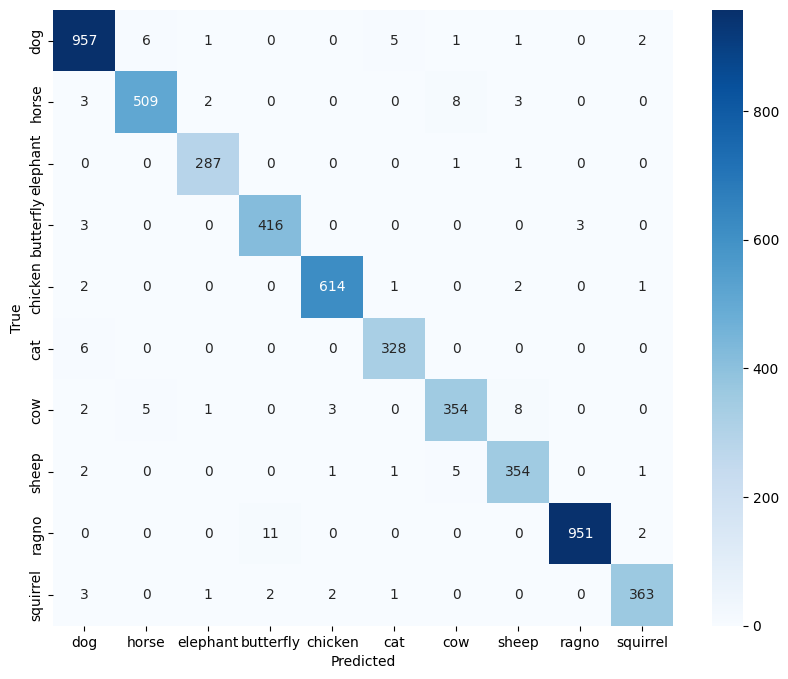

In [3]:
# ------------------------- Блок 1: Импорты -------------------------
print('hi')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Импорт словаря перевода
from translate import translate

# Проверка доступности GPU и установка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ------------------------- Блок 2: Параметры -------------------------

# Укажи путь к папке в формате для Windows
DATASET_DIR = r'c:/Users/admin/Desktop/model_resnet/new_datasets/raw-img'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-4
VAL_SPLIT = 0.2

# ------------------------- Блок 3: Подготовка данных -------------------------

# Трансформации для данных
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка всего датасета
full_dataset = datasets.ImageFolder(DATASET_DIR)

# Разделение на тренировочную и валидационную выборки
train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=VAL_SPLIT,
    stratify=full_dataset.targets,
    random_state=42
)

# Создание подмножеств с разными трансформациями
train_dataset = datasets.ImageFolder(
    DATASET_DIR,
    transform=train_transform
)
train_dataset = Subset(train_dataset, train_idx)

val_dataset = datasets.ImageFolder(
    DATASET_DIR,
    transform=val_transform
)
val_dataset = Subset(val_dataset, val_idx)

# Создание DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Получение информации о классах
class_names = full_dataset.classes
num_classes = len(class_names)

# ------------------------- Блок 4: Модель -------------------------

class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Замораживаем все слои
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Заменяем последний слой
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)

model = ResNet50Model(num_classes).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ------------------------- Блок 5: Callbacks и утилиты -------------------------

# Ранняя остановка
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

early_stopping = EarlyStopping(patience=5)

# Сохранение модели
def save_model(model, path='best_resnet50.pth'):
    torch.save(model.state_dict(), path)

# Планировщик обучения
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# ------------------------- Блок 6: Обучение -------------------------

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        
        # Валидация
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        
        # Обновление планировщика
        scheduler.step(val_loss)
        
        # Проверка ранней остановки
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
    
    return all_preds, all_labels

# Первый этап обучения (замороженные слои)
print("First stage training (frozen layers)")
all_preds, all_labels = train_model(model, train_loader, val_loader, EPOCHS, optimizer, criterion)

# ------------------------- Блок 7: Разморозка и дообучение -------------------------

# Размораживаем все слои
for param in model.resnet.parameters():
    param.requires_grad = True

# Новый оптимизатор с меньшим learning rate
optimizer = optim.Adam(model.parameters(), lr=LR/10)

# Второй этап обучения
print("Second stage training (unfrozen layers)")
all_preds, all_labels = train_model(model, train_loader, val_loader, 5, optimizer, criterion)

# ------------------------- Блок 8: Оценка -------------------------

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_resnet50.pth'))
model.eval()

# Переводим номера в названия классов
translated_labels = [translate.get(label, label) for label in class_names]

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=translated_labels))

# Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt="d", 
            xticklabels=translated_labels, yticklabels=translated_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()